In [1]:
import matplotlib
# matplotlib.use("TkAgg") - you can check this out - external viewport for Figures
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

In [2]:
## Load Data

In [3]:
df = pd.read_csv('talking_head.csv')

In [4]:
df.head()

,quote_id,quote,character
0,0,"Yes, I’d like to speak to your office manager,...",Michael
1,1,"People say I am the best boss. They go, “God w...",Michael
2,2,Corporate really doesn’t really interfere with...,Michael
3,3,"Am I going to tell them? No, I am not going to...",Michael
4,4,I think I’m a role model here. I think I garne...,Michael


In [5]:
## Preprocessing

In [6]:
# Normalize
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df.quote = df.quote.apply(normalize_document)
df.character = pd.Categorical(df.character)

In [8]:
## Split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.quote.values, df.character.cat.codes, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(1224,) (525,)


In [9]:
## Tokenize and Padding

In [10]:
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [11]:
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(X_train)
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

max_length = get_max_length(X_train)

X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

In [12]:
print("X_train vector shape = {}".format(X_train.shape))
print("X_test vector shape = {}".format(X_test.shape))

X_train vector shape = (1224, 17)
X_test vector shape = (525, 17)


In [30]:
## LSTM

In [27]:
input_dim = 25000
output_dim = 500
def train_model(Optimizer, X_train, y_train, X_val, y_val, input, output):
   model = Sequential()
   model.add(Embedding(input_dim = input, output_dim = output))
   model.add(LSTM(units=output))
   model.add(Dense(units=1, activation='sigmoid'))
   model.compile(loss='binary_crossentropy', optimizer = Optimizer, metrics=['accuracy'])
   scores = model.fit(X_train, y_train, batch_size=output, epochs=20, validation_data=(X_val, y_val))
   return scores, model

In [28]:

RMSprop_score, RMSprop_model = train_model('RMSprop', X_train, y_train, X_test, y_test, input_dim, output_dim)

Epoch 1/20
3/3 [==============================] - 9s 2s/step - loss: -0.7035 - accuracy: 0.1855 - val_loss: -11.0033 - val_accuracy: 0.1790
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: -12.8334 - accuracy: 0.1797 - val_loss: -14.2165 - val_accuracy: 0.1829
Epoch 3/20
3/3 [==============================] - 7s 2s/step - loss: -16.3347 - accuracy: 0.2018 - val_loss: -15.6784 - val_accuracy: 0.1829
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: -19.1222 - accuracy: 0.2459 - val_loss: -11.0196 - val_accuracy: 0.2267
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: -19.7437 - accuracy: 0.2606 - val_loss: -17.3328 - val_accuracy: 0.1848
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: -22.6599 - accuracy: 0.2639 - val_loss: -17.5204 - val_accuracy: 0.2114
Epoch 7/20
3/3 [==============================] - 6s 2s/step - loss: -24.2443 - accuracy: 0.2917 - val_loss: -18.1481 - val_accuracy: 0.2019
Epoch 8/20
3/3

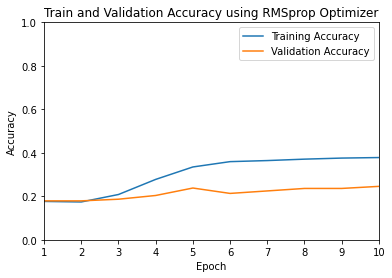

In [18]:
plt.plot(range(1,11), RMSprop_score.history['accuracy'], label='Training Accuracy') 
plt.plot(range(1,11), RMSprop_score.history['val_accuracy'], label='Validation Accuracy')
plt.axis([1, 10, 0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using RMSprop Optimizer')
plt.legend()
plt.show()

I was curious about LSTM for this dataset and it's not very peformant. Will Try alternative methods

In [35]:
## Exploring other methods

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.quote.values, df.character.cat.codes, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(1224,) (525,)


In [34]:
## Count Vectors
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,1))

# Train matrix
cv_matrix_train = cv.fit_transform(X_train)
cv_matrix_train = cv_matrix_train.toarray()

# Test matrix
cv_matrix_test = cv.transform(X_test)
cv_matrix_test = cv_matrix_test.toarray()

In [36]:
## TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tt = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)

# Train
tt_matrix_train = tt.fit_transform(cv_matrix_train)
tt_matrix_train = tt_matrix_train.toarray()

# Test
tt_matrix_test = tt.transform(cv_matrix_test)
tt_matrix_test = tt_matrix_test.toarray()

In [38]:
## Train Models

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [40]:
def train(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    cv_scores = cross_val_score(model, train_x, train_y, cv=5)
    mean_score = np.mean(cv_scores)
    test_score = model.score(test_x, test_y)
    
    return cv_scores, mean_score, test_score

In [41]:
classifiers = {
    "multiNB": {
        "model": MultinomialNB(alpha=1)
    },
    "log_reg": {
        "model": LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
    },
    "svc": {
        "model": LinearSVC(penalty='l2', C=1, random_state=42)
    },
    "sgd": {
        "model": SGDClassifier(loss='hinge', penalty='l2', max_iter=100, random_state=42)
    },
    "random_forest": {
        "model": RandomForestClassifier(n_estimators=10, random_state=42)
    },
    "gradient_boost": {
        "model": GradientBoostingClassifier(n_estimators=10, random_state=42)
    }
}

In [42]:
for key,val in classifiers.items():
    print(f"Training {key}:")
    cv_score, mean_score, test_score = train(val["model"], tt_matrix_train, y_train, tt_matrix_test, y_test)
    val["cv_score"] = cv_score
    val["mean_score"] = mean_score
    val["test_score"] = test_score

Training multiNB:
Training log_reg:
Training svc:
Training sgd:
Training random_forest:
Training gradient_boost:


In [43]:
pd.DataFrame.from_dict(classifiers)

,multiNB,log_reg,svc,sgd,random_forest,gradient_boost
model,MultinomialNB(alpha=1),"LogisticRegression(C=1, random_state=42)","LinearSVC(C=1, random_state=42)","SGDClassifier(max_iter=100, random_state=42)","(DecisionTreeClassifier(max_features='auto', r...",([DecisionTreeRegressor(criterion='friedman_ms...
cv_score,"[0.43673469387755104, 0.42857142857142855, 0.4...","[0.4530612244897959, 0.4448979591836735, 0.477...","[0.43673469387755104, 0.47346938775510206, 0.5...","[0.4163265306122449, 0.46122448979591835, 0.45...","[0.42857142857142855, 0.46122448979591835, 0.4...","[0.4448979591836735, 0.43673469387755104, 0.43..."
mean_score,0.433827,0.45999,0.469776,0.445269,0.446875,0.437093
test_score,0.426667,0.48,0.481905,0.459048,0.453333,0.447619


SVC is the most performant so that will be my model of choice

In [46]:
## Main Functionality: Prediction

In [54]:
labels = dict( enumerate(df['character'].cat.categories ) )
def predict(model, x_test, y_test, labels):
  preds = classifiers["svc"]["model"].predict(tt_matrix_test)
  df_results = pd.DataFrame()
  df_results["quote"] = X_test
  df_results["target_label"] = np.array(y_test)
  df_results["target_name"] = df_results["target_label"].replace(labels)
  df_results["predicted_label"] = preds
  df_results["predicted_name"] = df_results["predicted_label"].replace(labels)

  return df_results

In [55]:
predict(classifiers["svc"]["model"], tt_matrix_test, y_test, labels)

,quote,target_label,target_name,predicted_label,predicted_name
0,two whistleblowers two always thought darryl p...,2,Michael,1,Jim
1,comanaging give take pick battles one battles ...,1,Jim,2,Michael
2,yes decided shun andy bernard next three years...,0,Dwight,0,Dwight
3,see thats christmas see someone open gift thin...,2,Michael,1,Jim
4,heres thing company screws best thing call pre...,2,Michael,2,Michael
...,...,...,...,...,...
520,know pam pretty well know things likes importa...,1,Jim,2,Michael
521,whos ready work,0,Dwight,0,Dwight
522,dont need friends pam plenty female friends mo...,2,Michael,1,Jim
523,didnt tell michael thought hed try help exampl...,1,Jim,3,Pam


This is a fun project and I feel I've managed milestones and expectations well as a solo project contributor. I'm happy I was able to implement the neural network knowledge we learned during this weeks lecture. I think if the dataset was larger, the NN would be more performant. Overall, I'm on pace and should complete this project as I projected.